In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import uproot
import uproot3
import R2h_module_2d as r2h
import root_pandas as rpd
from root_pandas import read_root
from matplotlib import rc
import seaborn as sns
import cupy as cp, math, pylab
import os, os.path
mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 13}) 
mpl.rcParams.update({'ytick.labelsize': 13}) 
mpl.rcParams.update({'text.usetex' : False})
rc('font', weight='bold')
colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'


plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

Welcome to JupyROOT 6.27/01


/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


**Definition of some constants**

In [2]:
#change this to where you want to save the output plots

plots_dir='/home/sebouh/Documents/Overleaf_git/Dihadron2D_AN/figures/results/main/'
tables_dir='/home/sebouh/Documents/Overleaf_git/Dihadron2D_AN/tables'


# Get data from Ntuples to dataframes

In [3]:
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    file = uproot.open(filename) 
    tree=file[treename]
    df=tree.arrays(filter_name='*',library='pd')
    return df

# Getting Data

In [4]:
%%time
df = {}
df_trigger = {}
#path_data="/home/sebouh/di-hadron"
path_data="/home/seba/di-hadron/P27"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%s/Pairs_%s.root'%(path_data,target), target)
    df['D_%s'%target]= getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                      '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%s/Pairs_%s.root'%(path_data,target), 
                                                        'D_%s_trigger'%target)

Getting dataframes from target C
Get trigger dataframes from deuterium target C
Getting dataframes from target Fe
Get trigger dataframes from deuterium target Fe
Getting dataframes from target Pb
Get trigger dataframes from deuterium target Pb
CPU times: user 4.08 s, sys: 317 ms, total: 4.4 s
Wall time: 4.39 s


In [5]:
print(df['C'].columns)

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_Chi2CC',
       'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC', 'evnt'],
      dtype='object')


In [6]:
#df['C'].hist(figsize=(12,12),bins=100,column=['nu','t','Q2','h2_pid', 'h1_pid','h1_xf', 'h2_xf'])
#plt.show()

# Getting GiBUU

In [7]:
%%time

pathGIBUU="/home/miguel/eg2dihadron/"
for target in ['D','C','Fe','Pb']:
    #GiBUU
    print (target)
    print (' trigger')
    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), 
                                                           '%s_trigger'%target)
    print (' pairs')
    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(pathGIBUU,target), target)
print (df_trigger.keys())

D
 trigger
 pairs
C
 trigger
 pairs
Fe
 trigger
 pairs
Pb
 trigger
 pairs
dict_keys(['C_trigger', 'D_C_trigger', 'Fe_trigger', 'D_Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'GiBUU_D_trigger', 'GiBUU_C_trigger', 'GiBUU_Fe_trigger', 'GiBUU_Pb_trigger'])
CPU times: user 14.6 s, sys: 776 ms, total: 15.3 s
Wall time: 15.3 s


# Apply selection to datasets
**Here are applied the cuts for GiBUU**

In [8]:
%%time
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('\nkey: ',key)
    df[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df[key].rename(columns={'h2_FidCut':'h2_FidCutPiPlus'}, inplace=True)
    df[key] = r2h.applyCuts(df[key],isMC=isMC, nomCuts=True)
    df[key] = r2h.applyCutsPair(df[key],isMC=isMC, nomCuts=True)


key:  C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44785  (100.00  %)
2.2 < nu < 4.2 44785  (100.00  %)
10<h2_th 35415  (100.00  %)
10< h1_th 32420  (100.00  %)

key:  D_C
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 67923  (100.00  %)
2.2 < nu < 4.2 67923  (100.00  %)
10<h2_th 57108  (100.00  %)
10< h1_th 52003  (100.00  %)

key:  Fe
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 44134  (100.00  %)
2.2 < nu < 4.2 44134  (100.00  %)
10<h2_th 34975  (100.00  %)
10< h1_th 32056  (100.00  %)

key:  D_Fe
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 96623  (100.00  %)
2.2 < nu < 4.2 96623  (100.00  %)
10<h2_th 82731  (100.00  %)
10< h1_th 75297  (100.00  %)

key:  Pb
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 15667  (100.00  %)
2.2 < nu < 4.2 15667  (100.00  %)
10<h2_th 12349  (100.00  %)
10< h1_th 11283  (100.00  %)

key:  D_Pb
Starting election on dipion variables
This is Data
1.0< Q2 <4.0 10

In [9]:
for key in df_trigger.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True    
    print (key, isMC)
    df_trigger[key].rename(columns={'h1_FidCut':'h1_FidCutPiPlus'}, inplace=True)
    df_trigger[key] = r2h.applyCuts(df_trigger[key],isTrigger=True, isMC=isMC, nomCuts=True)
    print (' ')
    
    

C_trigger False
 
D_C_trigger False
 
Fe_trigger False
 
D_Fe_trigger False
 
Pb_trigger False
 
D_Pb_trigger False
 
GiBUU_D_trigger True
 
GiBUU_C_trigger True
 
GiBUU_Fe_trigger True
 
GiBUU_Pb_trigger True
 


In [10]:
df['GiBUU_C'].columns

Index(['dphi', 'dphi_lab', 'qt', 'drap', 'h1_z', 'h2_z', 'z_tot', 'h1_xf',
       'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid', 'h1_cm_ph',
       'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt', 'mx_eh1h2',
       'Q2', 'x', 'nu', 'W', 'h1_ph', 'h1_th', 'h2_ph', 'h2_th', 'pos_x',
       'pos_y', 'pos_z', 'pos_x_asso', 'pos_y_asso', 'pos_z_asso', '__index__',
       'inelasticity', 'h1_e', 'h1_p', 'h2_e', 'h2_p', 'pair_pt2'],
      dtype='object')

In [15]:
#define the cuts used for the data.  These should be cleaned up for clarity
p_thr=2.7
Nphe_thr=5
minz2=0.05
maxz2=0.95
Nphe_h1_cut='h1_Nphe> (%d*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Nphe_h2_cut='h2_Nphe> (%d*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(Nphe_thr,p_thr,p_thr,p_thr,p_thr)                    
Chi2CC_h1_cut='h1_Chi2CC < (0.08726*( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) +10000* (not ( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
Chi2CC_h2_cut='h2_Chi2CC < (0.08726*( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) +10000* (not ( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) ) )'%(p_thr,p_thr,p_thr,p_thr)
StatCC_h1_cut='h1_StatCC>((( (h1_z*nu*h1_z*nu-0.13957*0.13957)>(%f*%f) and h1_pid==211 ) -1 ))'%(p_thr,p_thr)
StatCC_h2_cut='h2_StatCC>((( (h2_z*nu*h2_z*nu-0.13957*0.13957)>(%f*%f) and h2_pid==211 ) -1 ))'%(p_thr,p_thr)



pair_cut_nom  ='and h1_th>10 and h2_th>10 and h1_z>0.5 and h2_z>%s and h2_z<%s and (h1_p+h2_p)<nu and (h1_pid*h2_pid)<0.  and abs(h2_deltaZ)<3.0 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and h2_FidCutPiPlus==1 and %s and %s and %s and %s and %s and %s'%(minz2,maxz2, Nphe_h1_cut, Nphe_h2_cut,Chi2CC_h1_cut,Chi2CC_h2_cut,StatCC_h1_cut, StatCC_h2_cut)
trigger_cut_nom   ='h1_z>0.5 and h1_th>10 and abs(h1_deltaZ)<3.0 and TargType!=0 and SampFracEl25==1 and h1_FidCutPiPlus==1 and %s and %s and %s  '%(Nphe_h1_cut, Chi2CC_h1_cut,StatCC_h1_cut)

In [16]:
#set up some things regarding plotting style
import imp
imp.reload(mpl)
import mplhep as hep
hep.set_style("CMS")

symbols={"C":"o","Fe":"s", "Pb": "v"}
linestyles={"C":"-", "Fe":"--","Pb":"-."}

<ipython-input-16-fc33797c1d1a>:5: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("CMS")


# Determine the R2h values for each of the binnings.

In [17]:
import imp
import R2h_module_2d as r2h
imp.reload(r2h)
dphidy={}

trigger_cut_pid = {"+-":" and h1_pid==211","-+":" and h1_pid==-211"}
binsdy= {"+-": np.linspace(0, 3, 7), "-+": np.linspace(-0.5, 2, 6)}
for charge in "+-", "-+":
    for target in "C Fe Pb".split():
        
        dphidy[target+charge+"_data"]=r2h.getRatio2d(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                varx="dphi", vary='drap', bins=[np.linspace(0, np.pi, 9), binsdy[charge]],
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45 and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 and h1_z+h2_z<0.95'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid[charge] + " and h1_cm_pt**2>0.005")
        dphidy[target+charge+"_GiBUU"]=r2h.getRatio2d(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                varx="dphi", vary='drap', bins=[np.linspace(0, np.pi, 9), binsdy[charge]],
                                    pair_cut='and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95',
                                   trig_cut='h1_z>0.5'+trigger_cut_pid[charge])
        


In [18]:
import imp
import R2h_module_2d as r2h
imp.reload(r2h)
z1z2={}

trigger_cut_pid = {"+-":" and h1_pid==211","-+":" and h1_pid==-211"}
for charge in "+-", "-+":
    for target in "C Fe Pb".split():
        
        z1z2[target+charge+"_data"]=r2h.getRatio2d(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                varx="h2_z", vary='h1_z', bins=[np.linspace(.05, 0.45, 9), np.linspace(0.5, 0.90, 9)],
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid[charge])
        z1z2[target+charge+"_GiBUU"]=r2h.getRatio2d(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                varx="h2_z", vary='h1_z', bins=[np.linspace(.05, 0.45, 9), np.linspace(0.5, 0.90, 9)],
                                    pair_cut='and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95',
                                   trig_cut='h1_z>0.5'+trigger_cut_pid[charge])

/home/sebouh/di-hadron/R2h_module_2d.py:52: RuntimeWarning: invalid value encountered in true_divide
  ratio_conditional = np.true_divide(z_A,z_D)
/home/sebouh/di-hadron/R2h_module_2d.py:54: RuntimeWarning: divide by zero encountered in true_divide
  error_conditional=ratio_conditional*np.sqrt(1/n_A+1/n_D)
/home/sebouh/di-hadron/R2h_module_2d.py:52: RuntimeWarning: divide by zero encountered in true_divide
  ratio_conditional = np.true_divide(z_A,z_D)
/home/sebouh/di-hadron/R2h_module_2d.py:54: RuntimeWarning: invalid value encountered in multiply
  error_conditional=ratio_conditional*np.sqrt(1/n_A+1/n_D)


In [19]:
import imp
import R2h_module_2d as r2h
imp.reload(r2h)
z1dR={}

trigger_cut_pid = {"+-":" and h1_pid==211","-+":" and h1_pid==-211"}
for charge in "+-", "-+":
    for target in "C Fe Pb".split():
        
        z1dR[target+charge+"_data"]=r2h.getRatio2d(df['%s'%target], df['D_%s'%target], 
                                df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                                varx="sqrt(dphi**2+drap**2)", vary='h1_z', bins=[np.linspace(0, 4, 5), np.linspace(0.5, 0.9, 5)],
                                    pair_cut = '%s and h2_z>0.05 and h2_z<0.45 and h1_cm_pt**2>0.005 and h2_cm_pt**2>0.005 and h1_z+h2_z<0.95'%pair_cut_nom,
                                    trig_cut = '%s'%trigger_cut_nom +trigger_cut_pid[charge] + " and h1_cm_pt**2>0.005")
        z1dR[target+charge+"_GiBUU"]=r2h.getRatio2d(df['GiBUU_%s'%target],df['GiBUU_D'],
                                df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                                varx="sqrt(dphi**2+drap**2)", vary='h1_z', bins=[np.linspace(0, 4, 5), np.linspace(0.5, 0.9, 5)],
                                    pair_cut='and h2_z>0.05 and h2_z<0.45 and h1_z+h2_z<0.95',
                                   trig_cut='h1_z>0.5'+trigger_cut_pid[charge])

# Now make the plots:

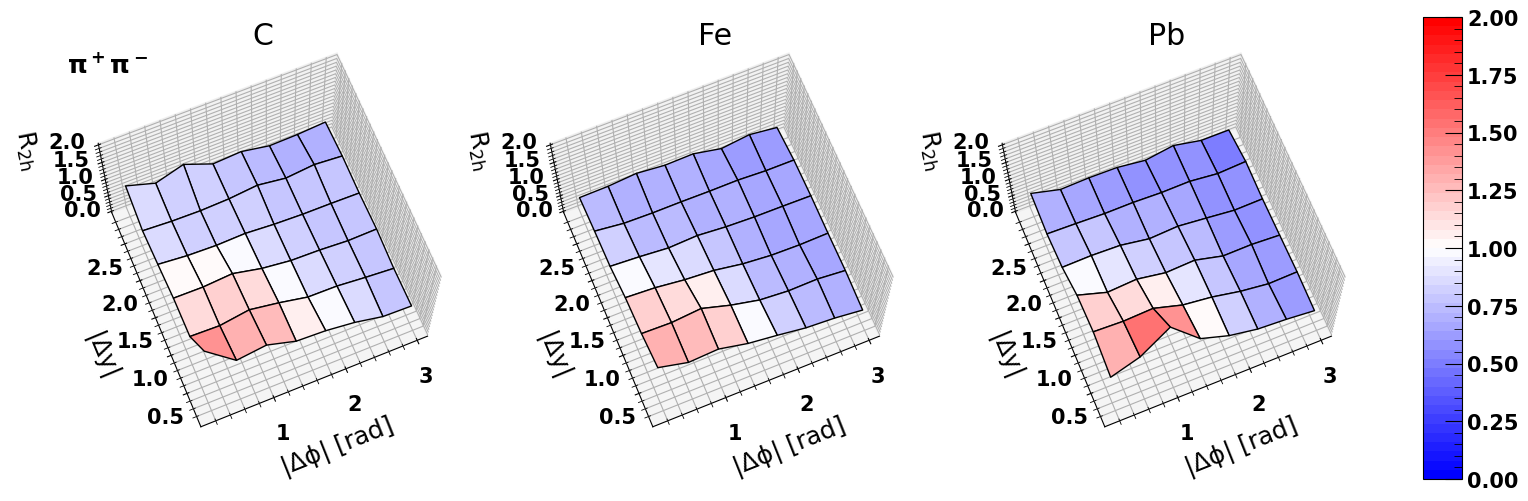

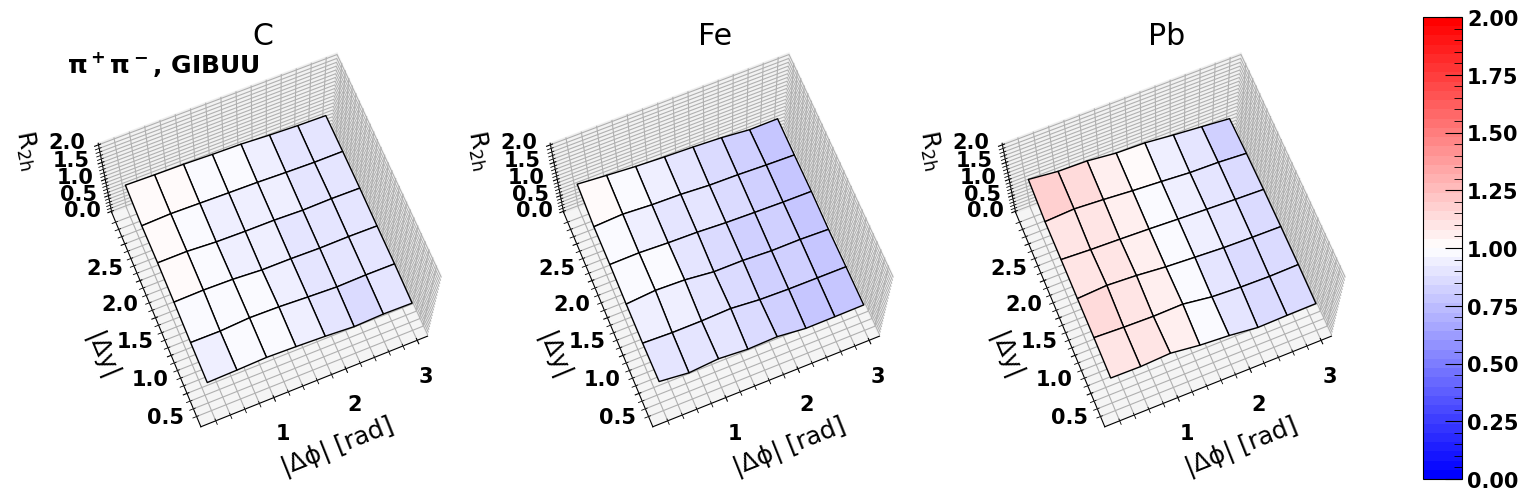

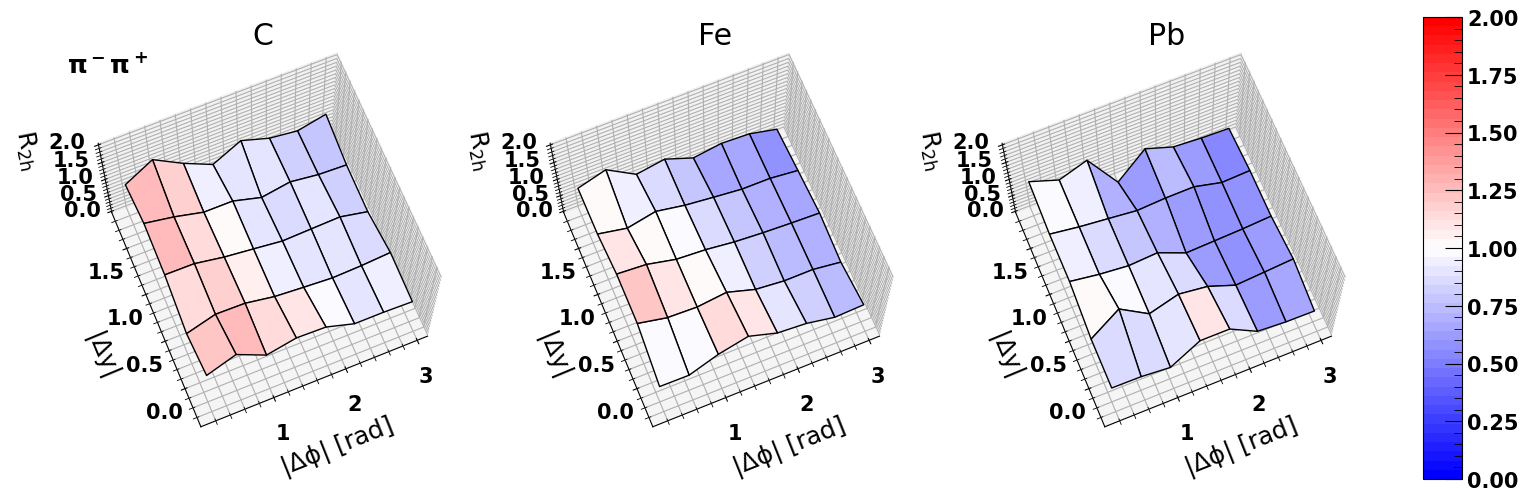

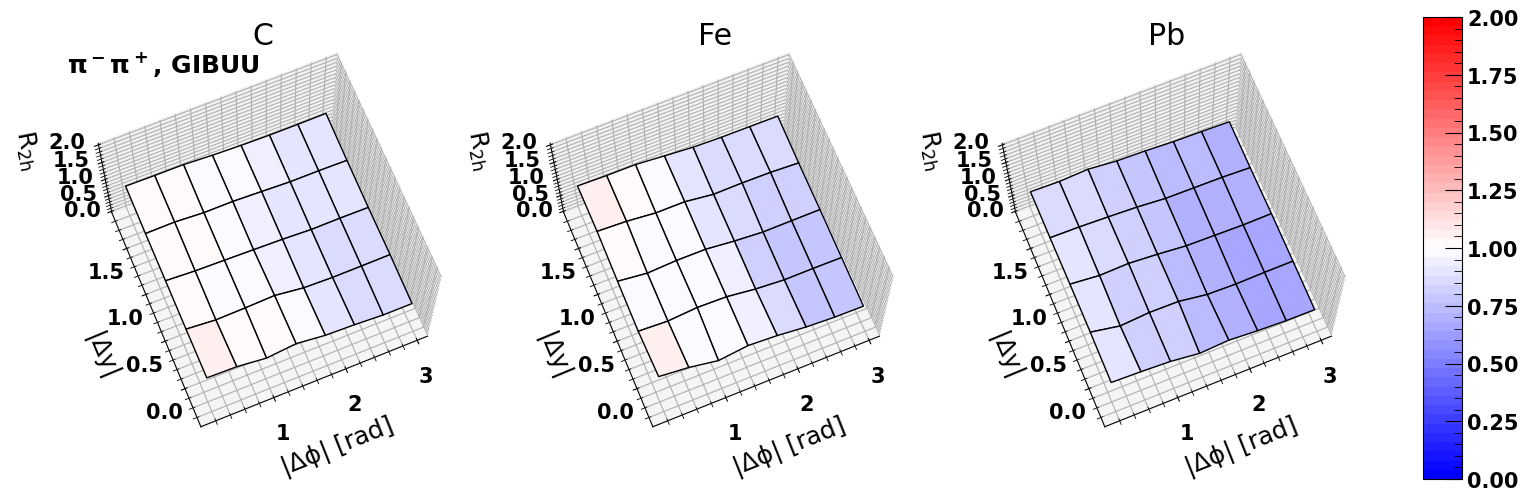

In [23]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
bwr = cm.get_cmap('bwr', 50)
for charge in "+-", "-+":
    for tag in "_data", "_GiBUU":
        
            
        fig = plt.figure(figsize=(18,6))
        gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1,1, 1, .1])
        for i, target in enumerate("C Fe Pb".split()):
            ax = fig.add_subplot(gs[0,i], projection='3d')
            ax.set_title(target)
            if i == 0:
                if tag == "_data":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$", transform=ax.transAxes)
                if tag == "_GiBUU":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$, GIBUU", transform=ax.transAxes)
            ax.set_zlim(0, 2)
            elev = 70
            azim = -112.5#-135
            ax.view_init(azim=azim,elev = elev)
            z, err, x, y = dphidy[target+charge+tag]
            x = (x[1:] + x[:-1])/2.0
            y = (y[1:] + y[:-1])/2.0
            xpos, ypos= np.meshgrid(x,y)
            #print(z, xpos, ypos)
            surf=ax.plot_surface(xpos, ypos, z.transpose(), cmap=bwr,edgecolor='k',vmin=0, vmax=2)
            ax.set_xlabel("$|\Delta\phi|$ [rad]", labelpad=15)
            ax.set_ylabel("$|\Delta y|$ ", labelpad=15)
            ax.set_zlabel("$R_{2h}$", labelpad=15)
        fig.colorbar(surf, orientation='vertical',cax=fig.add_subplot(gs[0,-1]))
        plt.savefig(f"{plots_dir}/R2h_dphidy_{charge}{tag}.png".replace("+", "p").replace("-","m"))
        plt.savefig(f"{plots_dir}/R2h_dphidy_{charge}{tag}.pdf".replace("+", "p").replace("-","m"))
        plt.show()

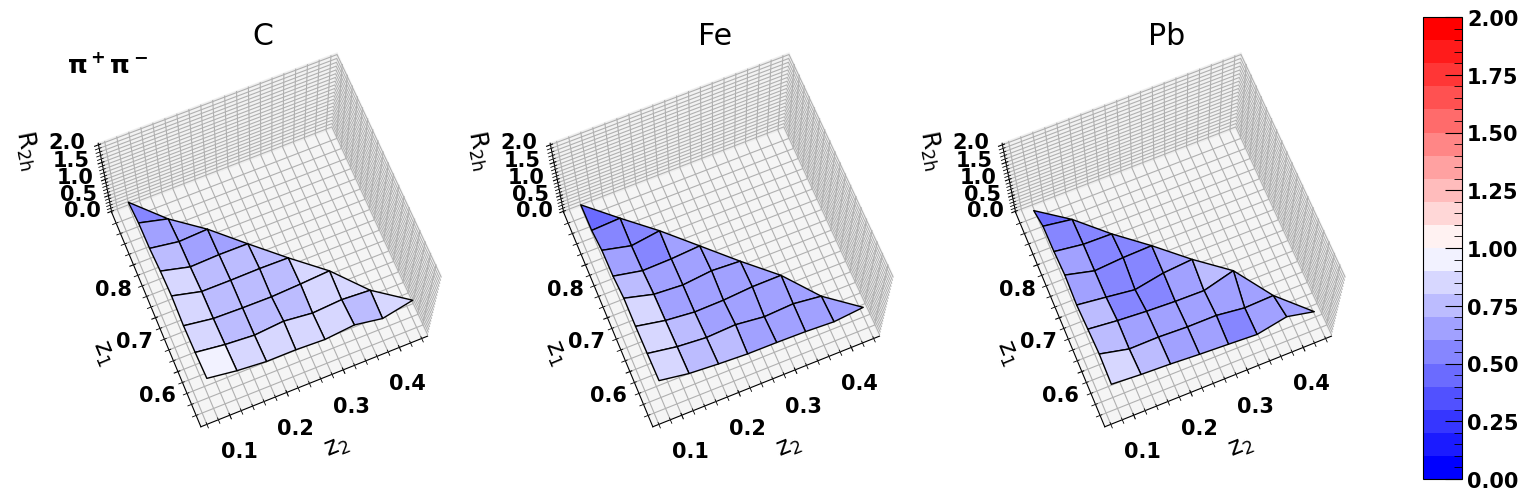

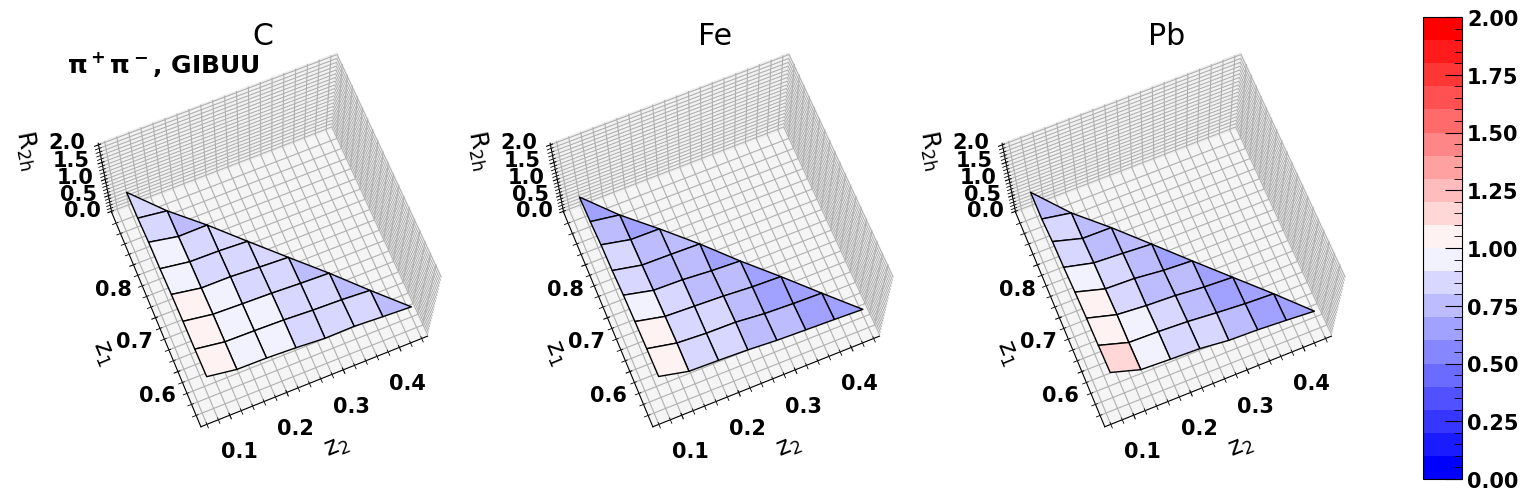

/home/sebouh/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/home/sebouh/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


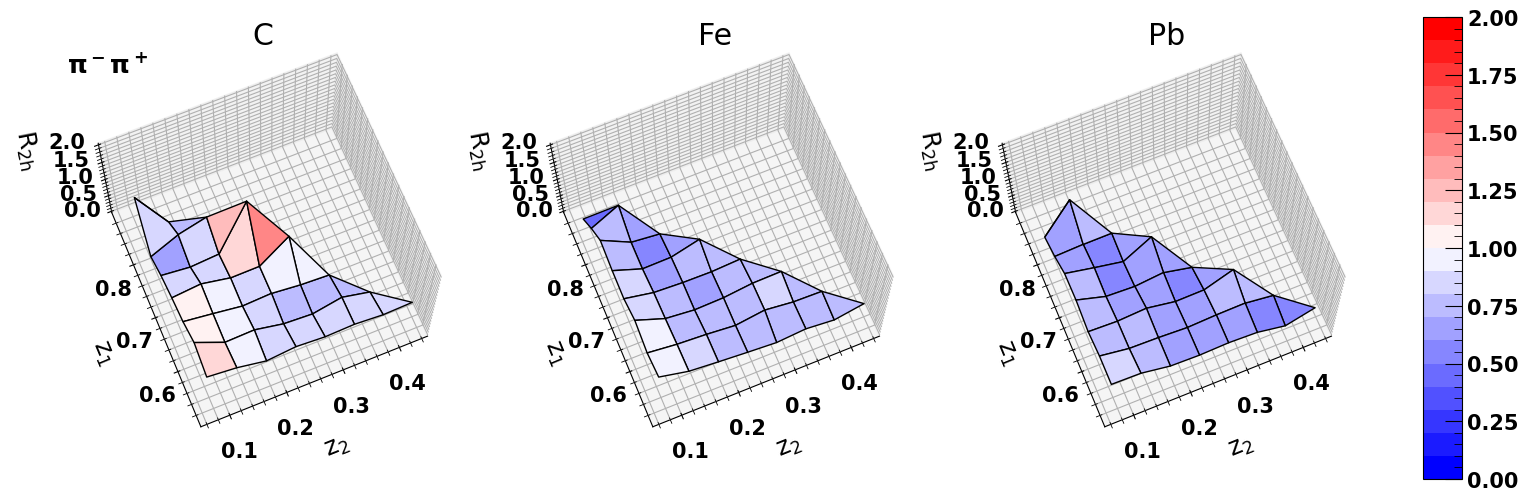

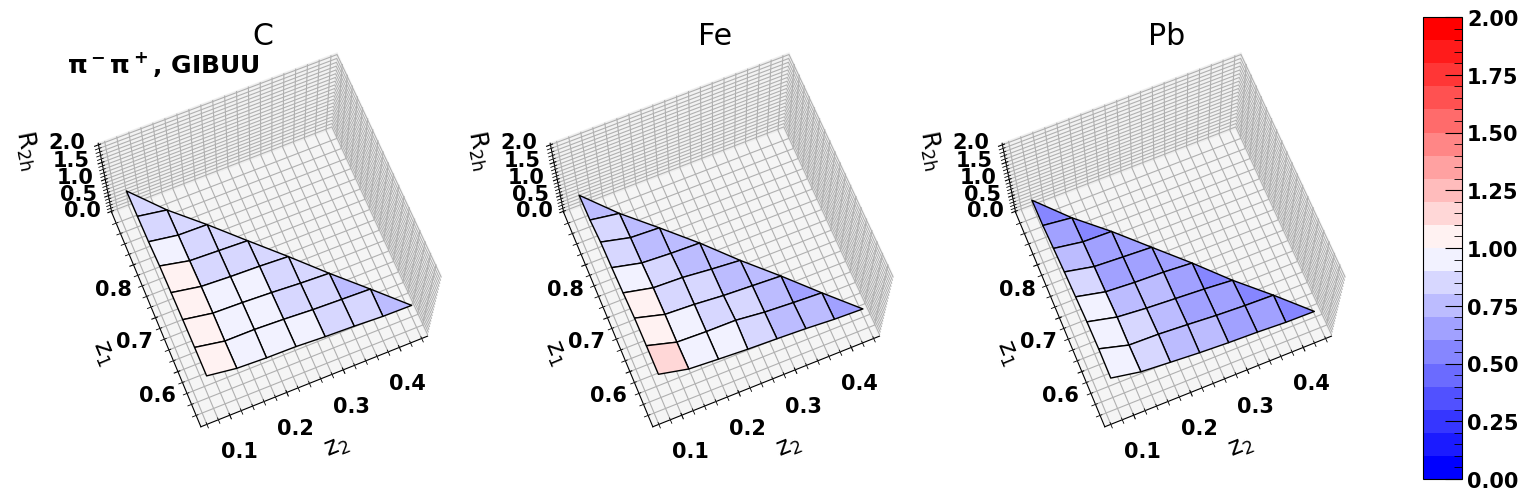

In [24]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
bwr = cm.get_cmap('bwr', 20)
for charge in "+-", "-+":
    for tag in "_data", "_GiBUU":
        fig = plt.figure(figsize=(18,6))
        gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1,1, 1, .1])
        for i, target in enumerate("C Fe Pb".split()):
            ax = fig.add_subplot(gs[0,i], projection='3d')
            if i == 0:
                if tag == "_data":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$", transform=ax.transAxes)
                if tag == "_GiBUU":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$, GIBUU", transform=ax.transAxes)
            ax.set_title(target)
            ax.set_zlim(0, 2)
            elev = 70
            azim = -112.5#-135
            ax.view_init(azim=azim,elev = elev)
            z, err, x, y = z1z2[target+charge+tag]
            x = (x[1:] + x[:-1])/2.0
            y = (y[1:] + y[:-1])/2.0
            xpos, ypos= np.meshgrid(x,y)
            #print(z, xpos, ypos)
            surf=ax.plot_surface(xpos, ypos, z.transpose(), cmap=bwr,edgecolor='k',vmin=0, vmax=2)
            ax.set_xlabel("$z_2$", labelpad=15)
            ax.set_ylabel("$z_1$ ", labelpad=15)
            ax.set_zlabel("$R_{2h}$", labelpad=15)
        fig.colorbar(surf, orientation='vertical',cax=fig.add_subplot(gs[0,-1]))
        plt.savefig(f"{plots_dir}/R2h_z1z2_{charge}{tag}.png".replace("+", "p").replace("-","m"))
        plt.savefig(f"{plots_dir}R2h_z1z2_{charge}{tag}.pdf".replace("+", "p").replace("-","m"))
        plt.show()

/home/sebouh/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w
/home/sebouh/.local/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:109: RuntimeWarning: invalid value encountered in true_divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


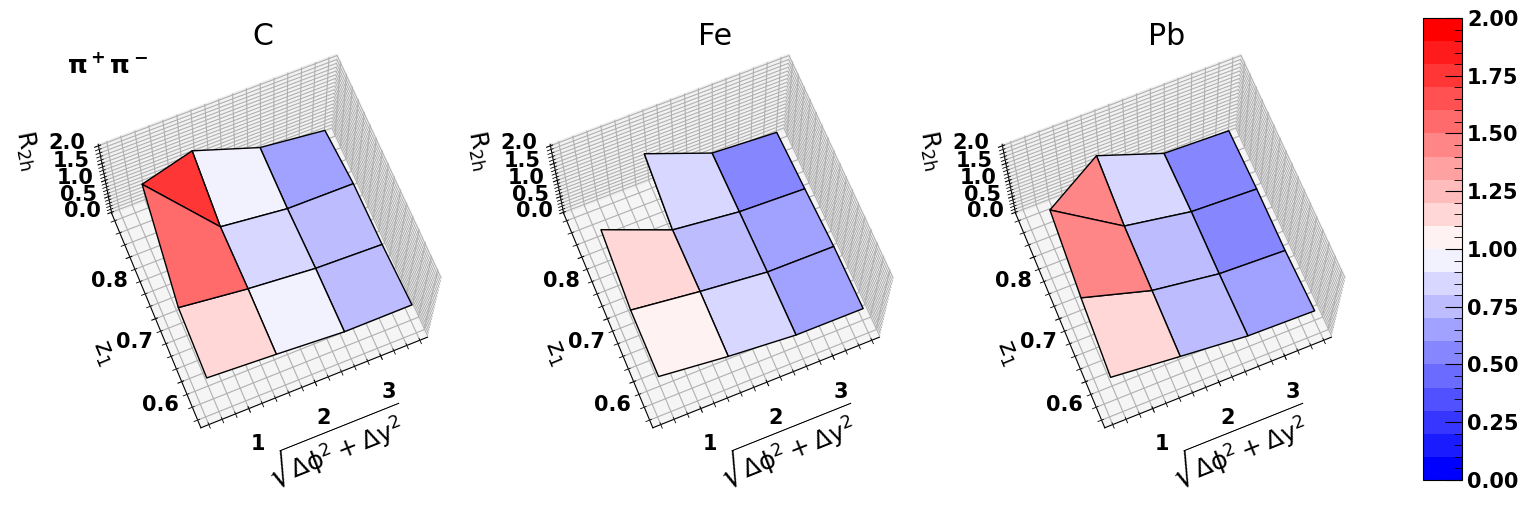

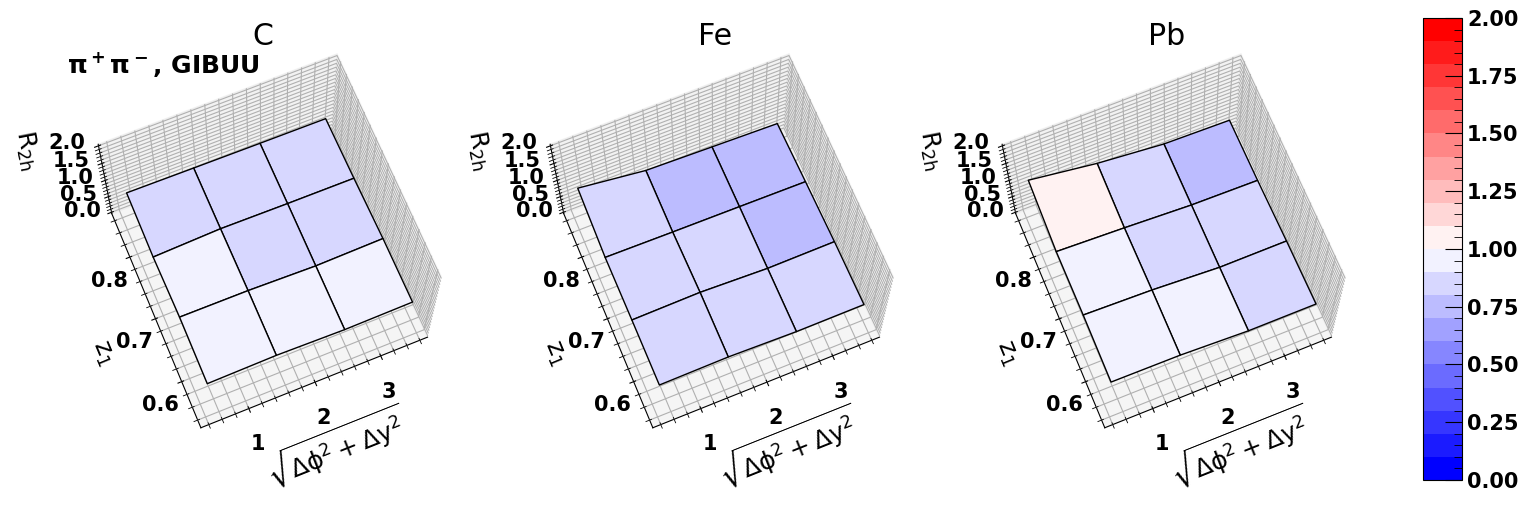

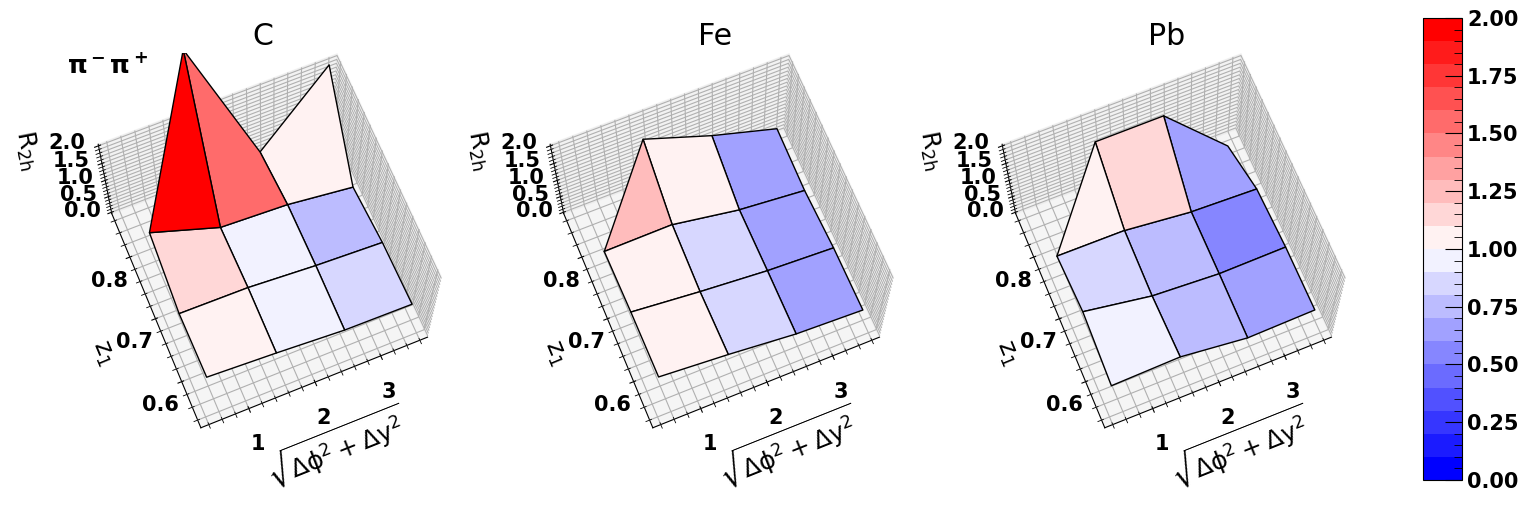

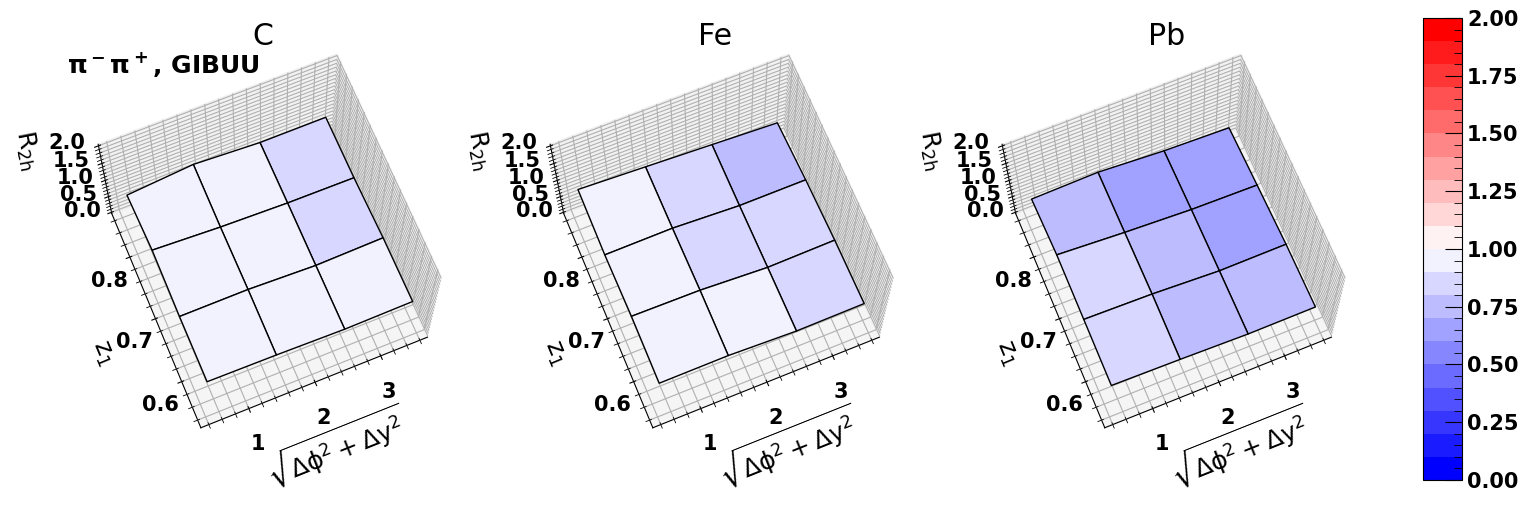

In [22]:
#z1 versus delta R=sqrt(Delta phi^2+Delta y^2)
from matplotlib import cm
viridis = cm.get_cmap('viridis', 12)
bwr = cm.get_cmap('bwr', 20)
for charge in "+-", "-+":
    for tag in "_data", "_GiBUU":
        fig = plt.figure(figsize=(18,6))
        gs = fig.add_gridspec(ncols=4, nrows=1, width_ratios=[1,1, 1, .1])
        for i, target in enumerate("C Fe Pb".split()):
            ax = fig.add_subplot(gs[0,i], projection='3d')
            if i == 0:
                if tag == "_data":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$", transform=ax.transAxes)
                if tag == "_GiBUU":
                    ax.text2D(0.0, 0.95, f"$\pi^{charge[0]}\pi^{charge[1]}$, GIBUU", transform=ax.transAxes)
            ax.set_title(target)
            ax.set_zlim(0, 2)
            elev = 70
            azim = -112.5#-135
            ax.view_init(azim=azim,elev = elev)
            z, err, x, y = z1dR[target+charge+tag]
            x = (x[1:] + x[:-1])/2.0
            y = (y[1:] + y[:-1])/2.0
            xpos, ypos= np.meshgrid(x,y)
            #print(z, xpos, ypos)
            surf=ax.plot_surface(xpos, ypos, z.transpose(), cmap=bwr,edgecolor='k',vmin=0, vmax=2)
            ax.set_xlabel("$\\sqrt{\Delta\phi^2+\Delta y^2}$", labelpad=15)
            ax.set_ylabel("$z_1$ ", labelpad=15)
            ax.set_zlabel("$R_{2h}$", labelpad=15)
        fig.colorbar(surf, orientation='vertical',cax=fig.add_subplot(gs[0,-1]))
        plt.savefig(f"{plots_dir}/R2h_z1dR_{charge}{tag}.png".replace("+", "p").replace("-","m"))
        plt.savefig(f"{plots_dir}R2h_z1dR_{charge}{tag}.pdf".replace("+", "p").replace("-","m"))
        plt.show()

# create tables of values to be included in the analysis note/paper

In [166]:
pm={"+-":"pm","-+":"mp"}
for charge in "+-", "-+":
    string=" & & C & Fe & Pb \\\\\n\\hline\n"
    x = dphidy[target+charge+"_data"][2]
    y = dphidy[target+charge+"_data"][3]
    
    for i in range(len(x)-1):
        for j in range(len(y)-1):
            if j == 0:
                string= string +f"${x[i]:.2f}<\\Delta\\phi<{x[i+1]:.2f}$"
            string= string + f" & ${y[j]:.1f}<\\Delta y<{y[j+1]:.1f}$"
            for target in "C Fe Pb".split():
               string= string+f" & ${float(dphidy[target+charge+'_data'][0][i][j]):.3f}\\pm{dphidy[target+charge+'_data'][1][i][j]:.3f}$"
            string= string + "\\\\\n"
        string += "\\hline\n"
    f = open(tables_dir+f"/dphidy_{pm[charge]}_data.tex", "w")
    f.write(string)
    f.close()
    print("data, dphidy", charge)
    print(string)
    
for charge in "+-", "-+":
    string=" & & C & Fe & Pb \\\\\n"
    x = z1z2[target+charge+"_data"][2]
    y = z1z2[target+charge+"_data"][3]
    
    for j in range(len(y)-1):
        for i in range(len(x)-1):
            if i == 0:
                line = f"\\hline\n${y[j]:.2f}<z_1<{y[j+1]:.2f}$"
            else :
                line =""
            line +=f" & ${x[i]:.2f}<z_2<{x[i+1]:.2f}$"
            for target in "C Fe Pb".split():
               line += f" & ${float(z1z2[target+charge+'_data'][0][i][j]):.3f}\\pm{z1z2[target+charge+'_data'][1][i][j]:.3f}$"
            line+="\\\\\n"
            if "nan" not in line:
                string+= line
    string+="\\hline"
    f = open(tables_dir+f"/z1z2_{pm[charge]}_data.tex", "w")
    f.write(string)
    f.close()
    print("data, z1z2", charge)
    print(string)

data, dphidy +-
 & & C & Fe & Pb \\
\hline
$0.00<\Delta\phi<0.39$ & $0.0<\Delta y<0.5$ & $2.088\pm0.575$ & $1.495\pm0.312$ & $1.137\pm0.418$\\
 & $0.5<\Delta y<1.0$ & $1.165\pm0.127$ & $1.269\pm0.125$ & $1.331\pm0.188$\\
 & $1.0<\Delta y<1.5$ & $1.127\pm0.083$ & $1.145\pm0.074$ & $1.228\pm0.116$\\
 & $1.5<\Delta y<2.0$ & $0.960\pm0.060$ & $0.895\pm0.049$ & $0.862\pm0.073$\\
 & $2.0<\Delta y<2.5$ & $0.816\pm0.058$ & $0.804\pm0.051$ & $0.715\pm0.072$\\
 & $2.5<\Delta y<3.0$ & $1.044\pm0.135$ & $0.684\pm0.082$ & $0.814\pm0.146$\\
\hline
$0.39<\Delta\phi<0.79$ & $0.0<\Delta y<0.5$ & $1.322\pm0.299$ & $1.246\pm0.239$ & $1.450\pm0.438$\\
 & $0.5<\Delta y<1.0$ & $1.134\pm0.127$ & $1.241\pm0.117$ & $1.289\pm0.182$\\
 & $1.0<\Delta y<1.5$ & $1.113\pm0.076$ & $1.089\pm0.063$ & $0.934\pm0.088$\\
 & $1.5<\Delta y<2.0$ & $0.876\pm0.050$ & $0.838\pm0.043$ & $0.877\pm0.070$\\
 & $2.0<\Delta y<2.5$ & $0.765\pm0.052$ & $0.699\pm0.045$ & $0.690\pm0.069$\\
 & $2.5<\Delta y<3.0$ & $0.792\pm0.100$ & $0.696